# Problem Set 3
# ECON622
# Pablo Valenzuela
# 09-24-2020

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quatecon-notebooks-julia", version = "0.8.0")

Activated /Users/pvalenzuelac/Project.toml
Info Project name quantecon-notebooks-julia activated, quatecon-notebooks-julia requested.


In [2]:
using LinearAlgebra, Statistics, Plots, Distributions, StatsPlots
using NLsolve, Polynomials, BenchmarkTools, QuadGK, ForwardDiff

# Exercise 4 Introduction to Types
Use your solution to Exercise 8(a/b) in [Introductory Examples](julia_by_example.html) to
create a specialized version of Newton’s method for `Polynomials` using the `derivative` function.

The signature of the function should be `newtonsmethod(p::Polynomial, x_0; tolerance = 1E-7, maxiter = 100)`,
where `p::Polynomial` ensures that this version of the function will be used anytime a polynomial is passed (i.e. dispatch).

Compare the results of this function to the built-in `roots(p)` function.


<a id='intro-types-ex-5'></a>

In [3]:
# Creating the function
function newtonsmethod(p::Polynomial, x_0; tolerance = 1E-9, maxiter = 10000)
    v_old = x_0
    normdiff = Inf
    iter=1
    p_prime = derivative(p)
    #D(p) = x -> ForwardDiff.derivative(p, x)
    #p_prime = D(f)
    
    while (normdiff>tolerance)&&(iter<maxiter)
        v_new = v_old - (p(v_old)/p_prime(v_old))
        normdiff = norm(v_new - v_old)
        
        #replace and continue
        v_old = v_new
        iter = iter +1
    end
    return(value = v_old, normdiff=normdiff, iter=iter)    
end

newtonsmethod (generic function with 1 method)

In [4]:
# Defining a Polynomial. I am finding just one root!!!!!
# Random initial guess
x0 = rand(-100:100)
q = Polynomial([-56,-1,1])
@show length(q)
v_old, normdiff, iter = newtonsmethod(q,x0)
#println("Fixed point = $v_old, and |f(x) - x| = $normdiff in $iter iterations")
#show_supertypes(typeof(f))
roots(q)

length(q) = 3


2-element Array{Float64,1}:
 -7.0
  8.0

My function only finds one root, while `roots()` finds the entire vector of roots. If the polynomial is of degree one, then my newtonsmethod function is the same. 

# Exercise 5 Introduction to types

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximates an integral with

$$
\int_{\underline{x}}^{\bar{x}} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = {\underline{x}},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $.

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * Exploit the fact that `AbstractRange` has constant step sizes to specialize the algorithm  
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * For this, build a uniform grid with `N` points on `[x̲, x̄]` – call the `f` function at those grid points and use the existing `trapezoidal(f, x)` from the implementation  


With these:
1. Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $.
2. From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values.
3. Consider trying different functions for $ f(x) $ and compare the solutions for various `N`.

When trying different functions, instead of integrating by hand consider using a high-accuracy
library for numerical integration such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/)

In [5]:
function trapezoidal(f::AbstractArray, x::AbstractArray)
    if !(length(f)==length(x))
       error("The dimensions of `f' and `x' must be the same.") 
    end
    N = length(x)
    aux = zeros(Float64, N-1)
    for i = 2:N
        aux[i-1] = 0.5*(f[i-1]+f[i])*(x[i]-x[i-1])
    end
    return(val = sum(aux))
end

trapezoidal (generic function with 1 method)

In [6]:
function trapezoidal(f::AbstractArray, x::AbstractRange)
    Δ = step(x)
    N = length(x)
    total = zero(eltype(x))
    
    for k=1:N
        weight = ((k == 1) || (k == N)) ?  Δ/2 : Δ   # ternary operation, Condition ? if true : if false
        total += weight * f[k]
    end
    return total

end

trapezoidal (generic function with 2 methods)

In [7]:
function trapezoidal(f::Function, x_low, x_up, N)
    if N ==1
      return total = 0.5*(x_up-x_low)*(f(x_up) + f(x_low))         
    else
        Δ = (x_up-x_low)/(N-1)
        total = zero(eltype(x_low))
        x=x_low
    
        for k=1:N
            weight = ((k == 1) || (k == N)) ?  Δ/2 : Δ   # ternary operation, Condition ? if true : if false
            total += weight * f(x)
            x += Δ
        end
    end
    return total

end

trapezoidal (generic function with 3 methods)

In [8]:
# Setting the range
x1 = 0.0:0.2:1.0
x2 = [0,0.2,0.4,0.6,0.8,1.0]


#Creating the function
f(x) = x^2

# Creating the arrays of the function evaluated @ x
f_x1 = f.(x1) 
f_x2 = f.(x2)

# Results
true_value, accuracy = quadgk(f, 0.0, 1.0)
@show res1 = trapezoidal(f_x1,x1) #Range
@show res2 = trapezoidal(f_x2,x2) #Array
@show res3 = trapezoidal(f, 0.0, 1.0, 5) #Numbers
@show true_value ;

res1 = trapezoidal(f_x1, x1) = 0.3400000000000001
res2 = trapezoidal(f_x2, x2) = 0.34
res3 = trapezoidal(f, 0.0, 1.0, 5) = 0.34375
true_value = 0.3333333333333333


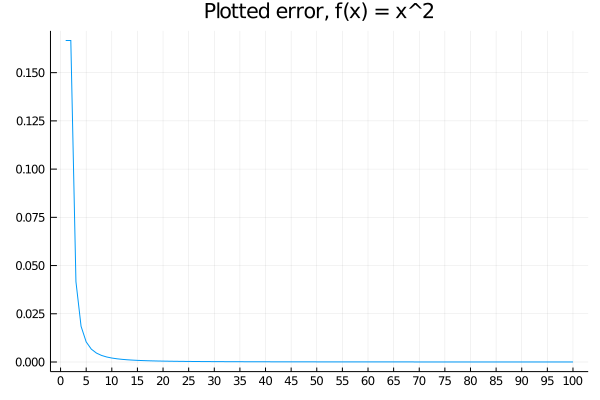

In [9]:
# Plotting the error of the trapezoidal function
f(x) = x^2
true_value, accuracy = quadgk(f, 0.0, 1.0)

# Since we are interested in the absolute difference between the true value and the result of `trapezoidal`, I will
# plot the absolute value! Without the abs value, it can be the image of this graph.

err = [abs(true_value - trapezoidal(f, 0.0, 1.0, n)) for n=1:100] 
plot(1:size(err)[1],err, xticks = 0:5:100, yticks = 0.00: 0.025 : 0.2,
        legend = false, title = "Plotted error, f(x) = x^2")

*The error goes to zero as N increases!*

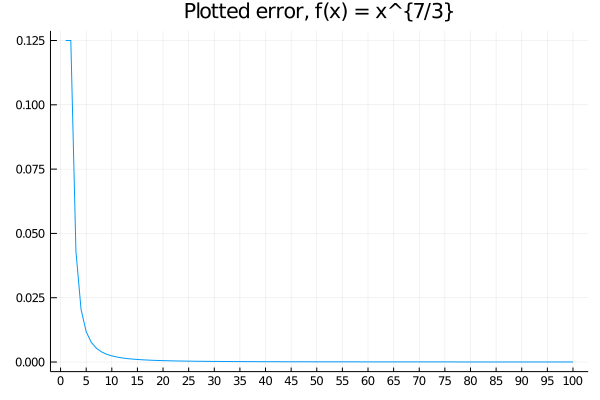

In [10]:
f(x) = x^7/3
true_value, accuracy = quadgk(f, 0.0, 1.0)
err = [abs(true_value - trapezoidal(f, 0.0, 1.0, n)) for n=1:100] 
plot(1:size(err)[1],err, xticks = 0:5:100, yticks = 0.00: 0.025 : 0.2,
        legend = false, title = "Plotted error, f(x) = x^{7/3}")

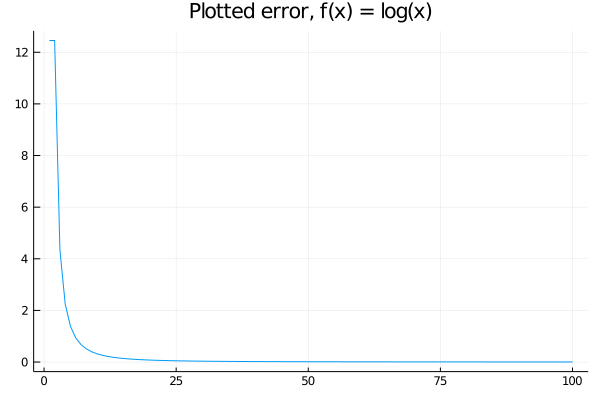

In [11]:
f(x) = log(x)
true_value, accuracy = quadgk(f, 1.0, 20.0)
err = [abs(true_value - trapezoidal(f, 1.0, 20.0, n)) for n=1:100] 
plot(1:size(err)[1],err, 
        legend = false, title = "Plotted error, f(x) = log(x)")

# Exercise 6 Introduction to types

Take a variation of your code in Exercise 5.

Use auto-differentiation to calculate the following derivative for the example functions

$$
\frac{d}{d {\bar{x}}}\int_{\underline{x}}^{\bar{x}} f(x) \, dx
$$

Hint: See the following code for the general pattern, and be careful to
follow the [rules for generic programming](#generic-tips-tricks).

In [12]:
f(x) =x^2
x_low = 1.0
N=50000

Df(x) = ForwardDiff.derivative(y -> trapezoidal(f,x_low,y,N),x)
@show f(2)
@show f(2.0001)
println(" ")


println("Testing")
@show Df(2)


f(2.0001) ≈ Df(2.0) #:(


f(2) = 4
f(2.0001) = 4.000400010000001
 
Testing
Df(2) = 4.000000000193206


false

In [13]:
# Testing different functions
f(x) = log(x)
x_low = 1.0
N=50000
Df(2)

0.6931471805177533

In [14]:
f(x) = sin(x)
x_low = 3.14
N=50000
Df(1.5708)

0.9999999998054395